<a href="https://colab.research.google.com/github/chiragbhatia94/ts-cds-classes/blob/main/M5_NB_MiniProject_01_MLR_MPI_OpenMP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Advanced Certification Program in Computational Data Science
## A program by IISc and TalentSprint
### Mini-Project: Implementation of Multiple Linear Regression using MPI and OpenMP

## Learning Objectives

At the end of the mini-project, you will be able to :

* understand the collective communication operations like scatter, gather, broadcast
* understand the blocking and non-blocking communication
* implement multiple linear regression and run it using MPI
* implement the multiple linear regression based predictions using OpenMP

### Dataset

The dataset chosen for this mini-project is [Combined Cycle Power Plant](https://archive.ics.uci.edu/ml/datasets/combined+cycle+power+plant). The dataset is made up of 9568 records and 5 columns. Each record contains the values for Ambient Temperature, Exhaust Vaccum, Ambient Pressure, Relative Humidity and Energy Output.

Predicting full load electrical power output of a base load power plant is important in order to maximize the profit from the available megawatt hours.  The base load operation of a power plant is influenced by four main parameters, which are used as input variables in the dataset, such as ambient temperature, atmospheric pressure, relative humidity, and exhaust steam pressure. These parameters affect electrical power output, which is considered as the target variable.

**Note:** The data was collected over a six year period (2006-11).

## Information

#### MPI in a Nutshell

MPI stands for "Message Passing Interface". It is a library of functions (in C / Python) or subroutines (in Fortran) that you insert into source code to perform data communication between processes. MPI was developed over two years of discussions led by the MPI Forum, a group of roughly sixty people representing some forty organizations.

To know more about MPI click [here](https://hpc-tutorials.llnl.gov/mpi/)


#### Multiple Linear Regression

Multiple regression is an extension of simple linear regression. It is used when we want to predict the value of a variable based on the value of two or more other variables. The variable we want to predict is called the dependent variable (or sometimes, the outcome, target or criterion variable). The variables we are using to predict the value of the dependent variable are called the independent variables (or sometimes, the predictor, explanatory or regressor variables).

**Note:** We will be using the mpi4py Python package for MPI based code implementation

## Grading = 20 Points

**Run the below code to install mpi4py package**

In [49]:
!pip install mpi4py

43285.84s - pydevd: Sending message related to process being replaced timed-out after 5 seconds



[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: pip install --upgrade pip


#### Importing Necessary Packages

In [50]:
# Importing pandas
import pandas as pd
# Importing Numpy
import numpy as np
# Importing MPI from mpi4py package
from mpi4py import MPI
# Importing sqrt function from the Math
from math import sqrt
# Importing Decimal, ROUND_HALF_UP functions from the decimal package
from decimal import Decimal, ROUND_HALF_UP
import time

#### Downloading the data

In [51]:
#@title Download the data
!wget -qq https://cdn.iisc.talentsprint.com/CDS/Datasets/PowerPlantData.csv

43291.82s - pydevd: Sending message related to process being replaced timed-out after 5 seconds


zsh:1: command not found: wget


### Overview

* Load the data and perform data pre-processing
* Identify the features, target and split the data into train and test
* Implement multiple Linear Regression by estimating the coefficients on the given data
* Use MPI package to distribute the data and implement `communicator`
* Define functions for each objective and make a script (.py) file to execute using MPI command
* Use OpenMP component to predict the data and calculate the error on the predicted data
* Implement the Linear Regression from `sklearn` and compare the results

#### Exercise 1: Load data (1 point)

Write a function that takes the filename as input and loads the data in a pandas dataframe with the column names as Ambient Temperature, Exhaust Vaccum, Ambient Pressure, Relative Humidity and Energy Output respectively.

**Hint:** read_csv()


In [52]:
#FILENAME = "/content/PowerPlantData.csv" # File path
FILENAME = "/Users/achappa/devhak/cds/M5/PowerPlantData.csv" #local file path

def loadData(filename):
    # Loading the dataset with first row as the header and the new column names as suggested
    data = pd.read_csv(filename, header=0,names=['Ambient Temperature','Exhaust Vaccum','Ambient Pressure','Relative Humidity','Energy Output'])
    return data
# Calling the function loadData and storing the dataframe in a variable named df

In [53]:
df = loadData(FILENAME)
df.head()

,Ambient Temperature,Exhaust Vaccum,Ambient Pressure,Relative Humidity,Energy Output
0,8.34,40.77,1010.84,90.01,480.48
1,23.64,58.49,1011.40,74.20,445.75
2,29.74,56.90,1007.15,41.91,438.76
3,19.07,49.69,1007.22,76.79,453.09
4,11.80,40.66,1017.13,97.20,464.43


#### Exercise 2: Explore data (1 point)

Write a function that takes the data loaded using the above defined function as input and explore it.

**Hint:** You can define and check for following things in the dataset inside a function

- checking for the number of rows and columns
- summary of the dataset
- check for the null values
- check for the duplicate values

In [54]:
# checking for the number of rows and columns
df.shape

(9568, 5)

In [55]:
# summary of the dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9568 entries, 0 to 9567
Data columns (total 5 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Ambient Temperature  9568 non-null   float64
 1   Exhaust Vaccum       9568 non-null   float64
 2   Ambient Pressure     9568 non-null   float64
 3   Relative Humidity    9568 non-null   float64
 4   Energy Output        9568 non-null   float64
dtypes: float64(5)
memory usage: 373.9 KB


In [56]:
# check for the null values
df.isnull().sum()

Ambient Temperature    0
Exhaust Vaccum         0
Ambient Pressure       0
Relative Humidity      0
Energy Output          0
dtype: int64

In [57]:
# check for the duplicate values
df.duplicated().sum()

41

In [58]:
# remove duplicate values
df.drop_duplicates(keep='first')

,Ambient Temperature,Exhaust Vaccum,Ambient Pressure,Relative Humidity,Energy Output
0,8.34,40.77,1010.84,90.01,480.48
1,23.64,58.49,1011.40,74.20,445.75
2,29.74,56.90,1007.15,41.91,438.76
3,19.07,49.69,1007.22,76.79,453.09
4,11.80,40.66,1017.13,97.20,464.43
...,...,...,...,...,...
9563,15.12,48.92,1011.80,72.93,462.59
9564,33.41,77.95,1010.30,59.72,432.90
9565,15.99,43.34,1014.20,78.66,465.96
9566,17.65,59.87,1018.58,94.65,450.93


#### Exercise 3: Handle missing data (1 point)

After exploring the dataset if there are any null values present in the dataset then define a function that takes data loaded using the above defined function as input and handle the null values accordingly.

**Hint:**

- Drop the records containing the null values - dropna()
- Replace the null values with the mean/median/mode - fillna()

In [59]:
# Function to handle missing data
# Drop the records containing the null values
df.dropna(inplace=True)
df.isnull().sum()

Ambient Temperature    0
Exhaust Vaccum         0
Ambient Pressure       0
Relative Humidity      0
Energy Output          0
dtype: int64

#### Exercise 4: Scale the data (1 point)

Write a function that takes the data after handling the missing data as input and returns the standardized data.

**Hint:**

- standardization of the data  can be performed using the below formula

$ (x - mean(x)) / std(x) $

In [60]:
# Defining a function to standardize the data

def standardize_data(df):
    # Create a copy of the dataframe to avoid modifying the original
    df_standardized = df.copy()

    # Get only numeric columns
    numeric_columns = df.select_dtypes('float64').columns

    # Standardize each numeric column
    for column in numeric_columns:
        mean = df_standardized[column].mean()
        std = df_standardized[column].std()

        # Avoid division by zero
        if std > 0:
            df_standardized[column] = (df_standardized[column] - mean) / std
        else:
            # If standard deviation is 0, just center the data
            df_standardized[column] = df_standardized[column] - mean

    return df_standardized

In [61]:
df_standardized = standardize_data(df)

In [82]:
df_standardized.head()

,Ambient Temperature,Exhaust Vaccum,Ambient Pressure,Relative Humidity,Energy Output
0,-1.517782,-1.065149,-0.407336,1.143885,1.530146
1,0.535228,0.329260,-0.313040,0.061028,-0.504776
2,1.353748,0.204141,-1.028675,-2.150575,-0.914338
3,-0.077992,-0.363223,-1.016888,0.238422,-0.074706
4,-1.053507,-1.073805,0.651804,1.636341,0.589734


#### Exercise 5: Feature selection (1 point)

Write a function that takes scaled data as input and returns the features and target variable values

**Hint:**

- Features: AmbientTemperature, ExhaustVaccum, AmbientPressure, RelativeHumidity
- Target Variable: EnergyOutput

In [63]:
import pandas as pd
import numpy as np

def prepare_power_plant_data(df):
    # Create a copy to avoid modifying the original
    df_copy = df.copy()

    # Seggregate features and target
    feature_cols = df_standardized.columns[:-1]
    target_col = df_standardized.columns[-1]

    # Create feature matrix X and target vector y
    X = df_copy[feature_cols]
    y = df_copy[target_col]

    return X, y

In [64]:
X, y = prepare_power_plant_data(df_standardized)

#### Exercise 6: Correlation (1 point)

Calculate correlation between the variables

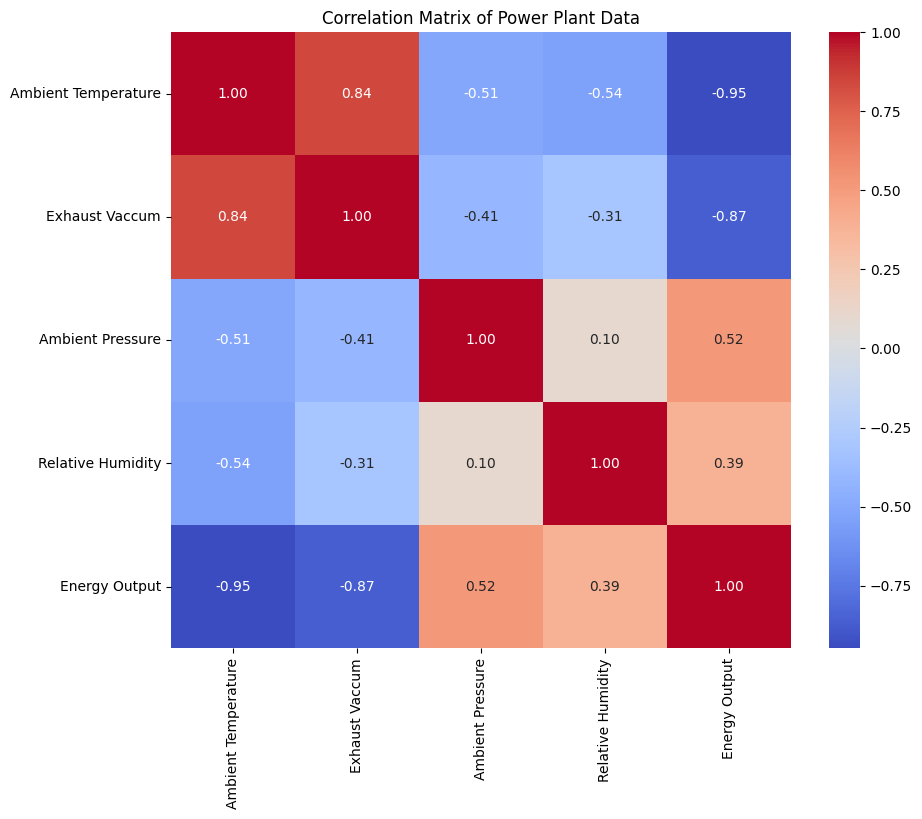

In [65]:
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming df_standardized is your DataFrame
correlation_matrix = df_standardized.corr()

# Plotting the correlation matrix using a heatmap
plt.figure(figsize=(10, 8))  # Adjust figure size as needed
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix of Power Plant Data')
plt.show()


#### Exercise 7: Estimate the coefficients (2 points)

Write a function that takes features and target as input and returns the estimated coefficient values

**Hint:**

- Calculate the estimated coefficients using the below formula

$ β = (X^T X)^{-1} X^T y $

- transpose(), np.linalg.inv()

In [66]:
# Calculating the coeffients

def estimate_coefficients(X_ec, y_ec):
    # Ensure X is a numpy array
    if isinstance(X_ec, pd.DataFrame):
        X_ec = X_ec.values
    if isinstance(y_ec, (pd.Series, pd.DataFrame)):
        y_ec = y_ec.values

    # Add intercept column (column of ones)
    X_intercept_ec = np.c_[np.ones(X_ec.shape[0]), X_ec]

    # Compute coefficients using the Normal Equation
    beta = np.linalg.inv(X_intercept_ec.T @ X_intercept_ec) @ X_intercept_ec.T @ y_ec
    return beta


In [67]:
estimate_coefficients(X,y)

array([-1.58380253e-15, -8.63500780e-01, -1.74171544e-01,  2.16029345e-02,
       -1.35210234e-01])

#### Exercise 8: Fit the data to estimate the coefficients (2 points)

Write a function named fit which takes features and targets as input and returns the intercept and coefficient values.

**Hint:**

- create a dummy column in the features dataframe which is made up of all ones
- convert the features dataframe into numpy array
- call the estimated coefficients function which is defined above
- np.ones(), np.concatenate()

In [68]:
# defining a fit function
def fit(X_fit, y_fit):
    # Call the estimate_coefficients function
    beta = estimate_coefficients(X_fit, y_fit)
    # First value is intercept, rest are coefficients
    intercept = beta[0]
    coefficients = beta[1:]
    return intercept, coefficients

In [69]:
intercept, coefficients = fit(X,y)

#### Exercise 9: Predict the data on estimated coefficients (1 point)

Write a function named predict which takes features, intercept and coefficient values as input and returns the predicted values.

**Hint:**

- Fit the intercept, coefficients values in the below equation

  $y = b_0 + b_1*x + ... + b_i*x_i$

In [70]:
 # fucntion to predict the values
def predict(x, intercept, coefficients):
    # Convert features to numpy array if it's a DataFrame
    if isinstance(X, pd.DataFrame):
        X_features = X.values
    else:
        X_features = X
    # Compute predictions
    y_pred = intercept + np.dot(X, coefficients)
    return y_pred

In [71]:
predict(X, intercept, coefficients)

array([ 1.33266027, -0.53453122, -0.93596031, ...,  0.52838115,
       -0.02266325, -0.41153611])

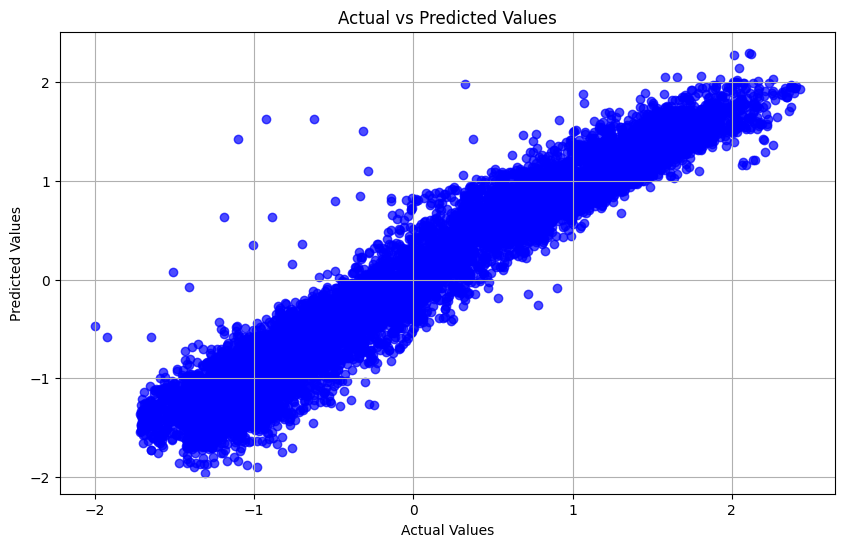

In [72]:
import matplotlib.pyplot as plt
y_pred = predict(X, intercept, coefficients)

# Plotting the predicted values
plt.figure(figsize=(10, 6))
plt.scatter(y, y_pred, color='blue', alpha=0.7)
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Actual vs Predicted Values")
plt.grid(True)
plt.show()


#### Exercise 10: Root mean squared error (1 point)

Write a function to calculate the RMSE error.

**Hint:**

- [How to calculate the RSME error](https://towardsdatascience.com/what-does-rmse-really-mean-806b65f2e48e)

In [73]:
# Define a function to calculate the error
def rmse(y_actual, y_pred):
    y_true = np.array(y_actual)
    y_pred = np.array(y_pred)
    mse = np.mean((y_actual - y_pred) ** 2)
    return np.sqrt(mse)

In [74]:
rmse(y, predict(X, intercept, coefficients))

0.26701396565722163

#### Exercise 11: Split the data into train and test (1 point)

Write a function named train_test_split which takes features and targets as input and returns the train and test sets respectively.

**Hint:**

- Shuffle the data
- Consider 70 % of data as a train set and the rest of the data as a test set

In [75]:
def train_test_split(features, targets, train_size=0.7, random_state=None):
    # Convert to numpy arrays if needed
    if isinstance(features, pd.DataFrame):
        X = features.values
    else:
        X = features
    if isinstance(targets, (pd.Series, pd.DataFrame)):
        y = targets.values
    else:
        y = targets

    # Set random seed for reproducibility
    rng = np.random.default_rng(random_state)
    indices = np.arange(X.shape[0])
    rng.shuffle(indices)

    # Calculate split index
    split_idx = int(train_size * X.shape[0])

    # Split the data
    X_train, X_test = X[indices[:split_idx]], X[indices[split_idx:]]
    y_train, y_test = y[indices[:split_idx]], y[indices[split_idx:]]

    return X_train, X_test, y_train, y_test

In [76]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, random_state=42)

#### Exercise 12: Implement predict using OpenMP (1 point)

Get the predictions for test data and calculate the test error(RMSE) by implementing the OpenMP (pymp)

**Hints:**

* Using the pymp.Parallel implement the predict function (use from above)

* Call the predict function by passing test data as an argument

* calculate the error (RMSE) by comparing the Actual test data and predicted test data

In [77]:
!pip install pymp-pypi

43298.32s - pydevd: Sending message related to process being replaced timed-out after 5 seconds



[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: pip install --upgrade pip


In [78]:
import pymp
import psutil
import platform
num_threads_new = psutil.cpu_count(logical=True)
print(f"Number of logical processors: {num_threads_new}")
def parallel_predict(features, intercept, coefficients, num_threads=num_threads_new):
    n_samples = features.shape[0]
    y_pred = pymp.shared.array(n_samples, dtype='float64')

    with pymp.Parallel(num_threads) as p:
        for i in p.range(n_samples):
            y_pred[i] = intercept + np.dot(features[i], coefficients)
    return np.array(y_pred)

Number of logical processors: 8


In [79]:
def rmse(y_true, y_pred):
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    mse = np.mean((y_true - y_pred) ** 2)
    return np.sqrt(mse)

In [80]:
# Get predictions in parallel
y_pred_test = parallel_predict(X_test, intercept, coefficients, num_threads=num_threads_new)

# Calculate RMSE
test_rmse = rmse(y_test, y_pred_test)
print("Test RMSE:", test_rmse)


Test RMSE: 0.2745043348588452


0.00s - Debugger warning: It seems that frozen modules are being used, which may
0.00s - make the debugger miss breakpoints. Please pass -Xfrozen_modules=off
0.00s - to python to disable frozen modules.
0.00s - Note: Debugging will proceed. Set PYDEVD_DISABLE_FILE_VALIDATION=1 to disable this validation.


In [81]:
    with pymp.Parallel(num_workers) as p:
    rank = p.thread_num
    # Shared list to hold the slices for each worker
    shared_slices = pymp.shared.list([None] * num_workers)
    # Shared counter to track when the master thread is done
    data_ready = pymp.shared.array(1, dtype='i')
    data_ready[0] = 0

    if rank == 0:
        # Root worker: prepare and divide the data
        X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, random_state=42)
        train_slices = dividing_data(X_train, y_train, num_workers)
        # Scatter: assign each slice to the shared list
        for i in range(num_workers):
            shared_slices[i] = train_slices[i]
        # Signal that data is ready
        data_ready[0] = 1

    # Wait until data is ready
    # Simple busy-wait synchronization
    while data_ready[0] == 0:
        # Small sleep to reduce CPU usage during waiting
        time.sleep(0.01)

    # Each worker gets its slice
    X_slice, y_slice = shared_slices[rank]
    # Fit model on the slice
    intercept, coefficients = fit(pd.DataFrame(X_slice), y_slice)
    # Predict on the slice
    yhat = predict(pd.DataFrame(X_slice), intercept, coefficients)
    print(f"Worker {rank}: Predicted yhat for its slice:\n", yhat)

IndentationError: expected an indented block after 'with' statement on line 1 (2514375854.py, line 2)

#### Exercise 13: Create a communicator (1 point) - MPI

Create a comunicator and define the rank and size

In [42]:
%%writefile rank.py
from mpi4py import MPI # Importing mpi4py package from MPI module
# Define a function
def main():
    # creating the communicator
    comm = MPI.COMM_WORLD
    # number of the process running the code i.e rank
    rank = comm.Get_rank()
    # total number of processes running i.e size
    size = comm.Get_size()
    # Displaying the rank and size of a communicator
    print("rank is {} and size is {}".format(rank,size))

# invoke the function
main()


Overwriting rank.py


In [34]:
num_threads_machine = psutil.cpu_count(logical=True)
print(f"Number of logical processors: {num_threads_machine}")

Number of logical processors: 8


In [43]:
!mpirun --allow-run-as-root --oversubscribe -np num_threads_machine python3 rank.py

rank is 4 and size is 8
rank is 6 and size is 8
rank is 0 and size is 8
rank is 7 and size is 8
rank is 2 and size is 8
rank is 3 and size is 8
rank is 5 and size is 8
rank is 1 and size is 8


#### Exercise 14: Divide the data into slices (1 point)

Write a function named dividing_data which takes train features set, train target set, and size of workers as inputs and returns the sliced data for each worker.

![img](https://cdn.iisc.talentsprint.com/CDS/Images/MiniProject_MPI_DataSlice.JPG)

For Example, if there are 4 processes, slice the data into 4 equal parts with 25% ratio

**Hint:**

- Divide the Data equally among the workers
  - Create an empty list
  - Iterate over the size of workers
  - Append each slice of data to the list

In [44]:
def dividing_data(x_train, y_train, size_of_workers):
    # Size of the slice
    slice_for_each_worker = int(Decimal(x_train.shape[0]/size_of_workers).quantize(Decimal('1.'), rounding = ROUND_HALF_UP))
    print('Slice of data for each worker: {}'.format(slice_for_each_worker))
    X = np.array(X_train)
    y = np.array(y_train)
    n_samples = X.shape[0]
    slices = []
    
    print('slice for each worker',slice_for_each_worker)

    for i in range(size_of_workers):
        start = i * slice_for_each_worker
        # For the last worker, take all remaining samples
        end = (i + 1) * slice_for_each_worker if i != size_of_workers - 1 else n_samples
        X_slice = X[start:end]
        y_slice = y[start:end]
        slices.append((X_slice, y_slice))
    return slices

In [47]:
print(num_threads_machine)
slices = dividing_data(X_train, y_train, num_threads_machine)
print('slices:',slices[0][0].shape)


8
Slice of data for each worker: 837
slice for each worker 837
slices: (837, 4)
<class 'list'>


#### Exercise 15: Prepare the data in root worker to assign data for all the workers (1 point)

- When it is the root worker, perform the below operation:
    - Store the features and target values in separate variables
    - Split the data into train and test sets using the train_test_split function defined above
    - Divide the data among the workers using the dividing_data function above

In [48]:
%%writefile root_worker_data_prep.py
from mpi4py import MPI # Importing mpi4py package from MPI module
# Defining a function
def data_prep_list():
    # Creating a communicator
    comm = MPI.COMM_WORLD
    # number of the process running the code
    rank = comm.Get_rank()
    # total number of processes running
    size = comm.Get_size()
    # master process
    if rank == 0:
        # Store the features and target values in separate variables
        # Split the data into train and test sets using the train_test_split function defined above
        # Divide the data among the workers using the dividing_data function above      
       X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, random_state=42)
       slices = dividing_data(X_train, y_train, num_threads_machine)
        # Scatter the slices to all worker processes
        for i in range(1, size):
            comm.send(slices[i], dest=i, tag=rank)
    # worker processes
    else:
        # each worker process receives data from master process
        data = comm.recv(source=0, tag=rank)
        # Displaying the results
        print('Process {} received data:'.format(rank), data)
# Calling the function
main()

Writing root_worker_data_prep.py


In [ ]:
def root_worker_data_preparation(features, target, num_workers):

    # Store the features and target values in separate variables
    X = features
    y = target

    # Split the data into train and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, random_state=42)

    # Divide the train data among the workers
    train_slices = dividing_data(X_train, y_train, num_workers)

    return X_train, X_test, y_train, y_test, train_slices

In [ ]:
num_workers = 4
with pymp.Parallel(num_workers) as p:
    #pragma omp parallel
    rank = p.thread_num
    if rank == 0:
        X_train, X_test, y_train, y_test, train_slices = root_worker_data_preparation(X, y, num_workers)

Slice of data for each worker: 1674


#### Exercise 16: Scatter and gather the data (1 point)

Perform the below operations:

- Send slices of the training set(the features data X and the expected target data Y) to every worker including the root worker
    - **Hint:** scatter()
    - use `barrier()` to block workers until all workers in the group reach a Barrier, to scatter from root worker.
- Every worker should get the predicted target Y(yhat) for each slice
- Get the new coefficient of each instance in a slice
    - **Hint:** fit function defined above
- Gather the new coefficient from each worker
    - **Hint:** gather()
    - Take the mean of the gathered coefficients
- Calculate the root mean square error for the test set

To know more about `scatter`, `gather` and `barrier` click [here](https://nyu-cds.github.io/python-mpi/05-collectives/)

#### Exercise 17: Make a script and execute everything in one place (1 point)

Write a script(.py) file which contains the code of all the above exercises in it so that you can run the code on multiple processes using MPI.

**Hint:**

- magic commands
- put MPI related code under main function
- !mpirun --allow-run-as-root -np 4 python filename.py

In [ ]:
# YOUR CODE HERE for scipt(.py)

In [ ]:
# YOUR CODE HERE for MPI command

#### Exercise 18: Use Sklearn to compare (1 point)

Apply the Linear regression on the given data using sklearn package and compare with the above results

**Hint:**
* Split the data into train and test
* Fit the train data and predict the test data using `sklearn Linear Regression`
* Compare the coefficients and intercept with above estimated coefficients
* calculate loss (RMSE) on test data and predictions and compare

In [ ]:
# YOUR CODE HERE